# Fitting 2D Epileptor model

In [2]:
import os
import sys
import time
import errno

import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [3]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [4]:
import pystan

In [5]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [32]:
plt.style.use('seaborn-talk');

In [33]:
cwd = os.getcwd()
cwd

'/home/meysam/Epileptor/Epileptor2D'

## Centerized form of parameterization

In [34]:
! cat epileptor_sde_euler_cen.stan

data {
    int nt;
    real dt;
    real eta_true;
    real x_init;
    real z_init;
    real xlim[2];
    real zlim[2];
    real I1;
    real tau0;
    vector[nt] xs;
}

transformed data {
}

parameters {
    vector<lower=xlim[1], upper=xlim[2]>[nt] x;
    vector<lower=zlim[1], upper=zlim[2]>[nt] z;
    real eta;  
    real <lower=0.0> amplitude;
    real offset; 
    real<lower=0.0> eps;   
    real<lower=0.0> sig;
    
}

model {
    vector[nt] xhat;
    vector[nt] zhat;

    x[1] ~ normal(x_init, 1.);
    z[1] ~ normal(z_init, 1.);
                         
    //eta ~ normal(eta_true, 1.); 

    amplitude ~ normal(1.,1.);
    offset ~ normal(0., 1.);
    eps ~ normal(0., 1.); 
    sig ~ normal(0., 1.);


    for (t in 1:(nt-1)) {
            real dx = 1.0 - x[t]*x[t]*x[t] - 2.0*x[t]*x[t] - z[t] + I1;
            real dz = (1.0/tau0)*(4*(x[t] - eta) - z[t] );
            x[t+1] ~ normal(x[t] + dt*dx, sqrt(dt)*sig); 
            z[t+1] ~ normal(z[t] + dt*dz, sqrt(dt)*sig);    
    }

In [109]:
model=str('epileptor_sde_euler_cen')

In [36]:
curr_dir=cwd

In [13]:
! cd /home/meysam/cmdstan-2.17.1 && make $curr_dir/$model && cd $curr_dir

make: Warning: File `/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_cen.stan' has modification time 133 s in the future

--- Translating Stan model to C++ code ---
bin/stanc  /home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_cen.stan --o=/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_cen.hpp
Model name=epileptor_sde_euler_cen_model
Input file=/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_cen.stan
Output file=/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_cen.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe

In [40]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=2000
warm_iter=2000

model=epileptor_sde_euler_cen
data_input=data_input_epileptor.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [113]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [114]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen'

In [115]:
! ls $dir_data_output

epileptor_sde_euler_cen_hmc_diagnose_4.log
epileptor_sde_euler_cen_summary_4.csv
output_hmc_epileptor_sde_euler_cen_1.csv
output_hmc_epileptor_sde_euler_cen_1.out
output_hmc_epileptor_sde_euler_cen_2.csv
output_hmc_epileptor_sde_euler_cen_2.out
output_hmc_epileptor_sde_euler_cen_3.csv
output_hmc_epileptor_sde_euler_cen_3.out
output_hmc_epileptor_sde_euler_cen_4.csv
output_hmc_epileptor_sde_euler_cen_4.out


In [116]:
!tail -n2 $dir_data_output/*$model*out

==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen/output_hmc_epileptor_sde_euler_cen_1.out <==
               2076.03 seconds (Total)


==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen/output_hmc_epileptor_sde_euler_cen_2.out <==
               2056.22 seconds (Total)


==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen/output_hmc_epileptor_sde_euler_cen_3.out <==
               2084.94 seconds (Total)


==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen/output_hmc_epileptor_sde_euler_cen_4.out <==
               2074.91 seconds (Total)



In [117]:
chain=4

In [118]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_epileptor_sde_euler_cen_4.csv'

Start of report!
Report directory: /home/meysam/Epileptor/Epileptor2D
------------------------------------------------------------
dynamic_type:  stochastic_cen
------------------------------------------------------------
Report starts!
csv file directory: /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen/output_hmc_epileptor_sde_euler_cen_4.csv
script_dir: /home/meysam/Epileptor/Epileptor2D
repor_filename: output_hmc_epileptor_sde_euler_cen_4
------------------------------------------------------------
parameters and their shapes: 
lp__ (2000,)
accept_stat__ (2000,)
stepsize__ (2000,)
treedepth__ (2000,)
n_leapfrog__ (2000,)
divergent__ (2000,)
energy__ (2000,)
x (2000, 1000)
z (2000, 1000)
eta (2000,)
amplitude (2000,)
offset (2000,)
eps (2000,)
sig (2000,)
xhat_q (2000, 1000)
zhat_q (2000, 1000)
x_ppc (2000, 1000)
z_ppc (2000, 1000)
log_lik (2000, 1000)
------------------------------------------------------------
max_log_lik: 1.46126
------------------------

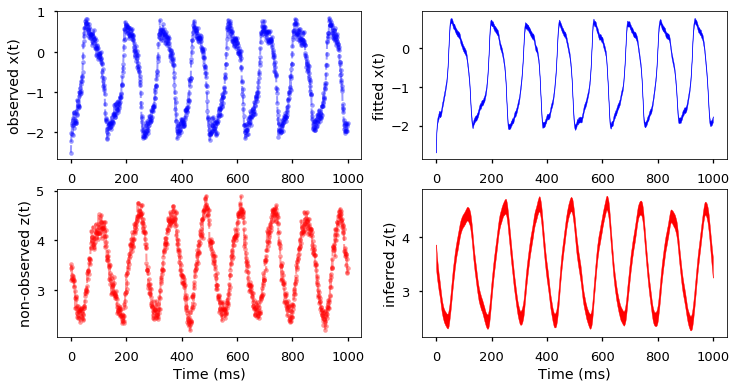

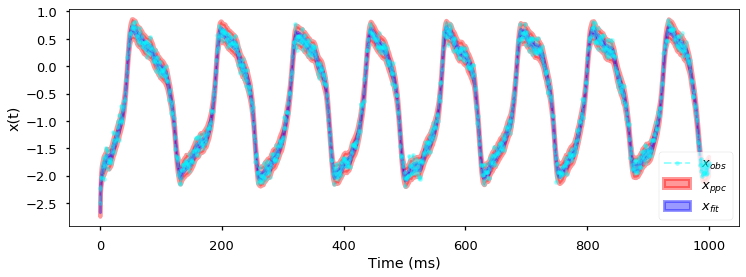

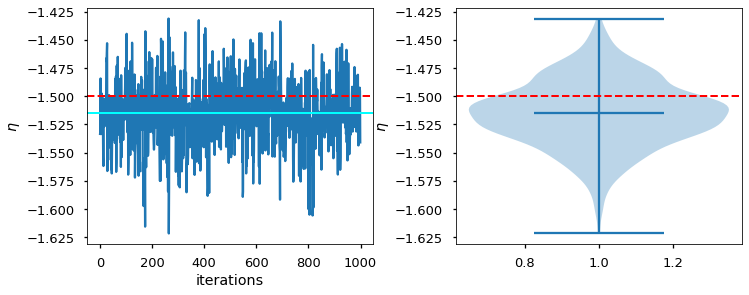

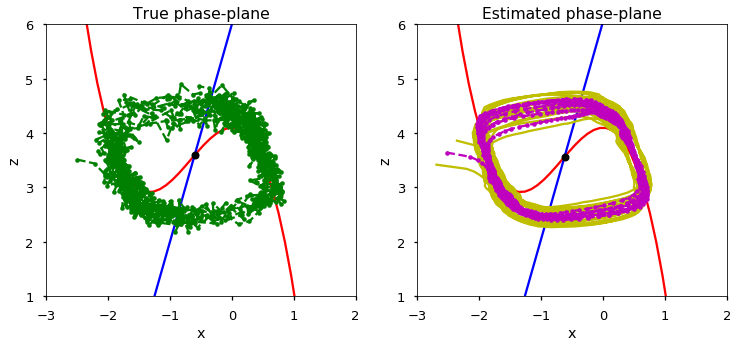

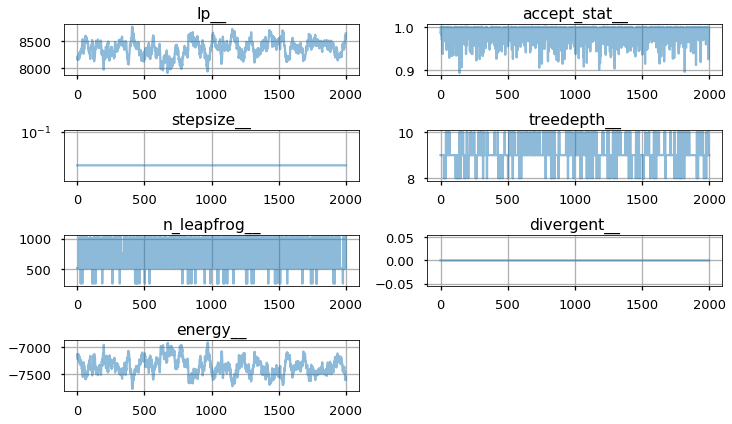

------------------------------------------------------------
End of report!
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


In [119]:
run report_epileptor2D.py $dir_data_output/$cvsfinemane

In [120]:
diagname=model+'_hmc_diagnose_'+str(chain)+'.log'
summaryname=model+'_summary_'+str(chain)+'.csv'
diagname, summaryname

('epileptor_sde_euler_cen_hmc_diagnose_4.log',
 'epileptor_sde_euler_cen_summary_4.csv')

In [121]:
!/home/meysam/cmdstan-2.17.1/bin/diagnose  $dir_data_output/$cvsfinemane > $dir_data_output/$diagname
! cat $dir_data_output/$diagname

154 of 2000 (7.7%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps. Trajectories that are prematurely terminated due to this limit will result in slow exploration and you should increase the limit to ensure optimal performance.

The E-BFMI, 0.091, is below the nominal threshold of 0.3 which suggests that HMC may have trouble exploring the target distribution.  You should consider any reparameterizations if possible.



In [122]:
%%capture
!/home/meysam/cmdstan-2.17.1/bin/stansummary --csv_file=$dir_data_output/$summaryname $dir_data_output/$cvsfinemane

In [123]:
from stan_utility import plot_rhat

filepath: /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen
filename: epileptor_sde_euler_cen_summary_4
mycsvfile: /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_cen/epileptor_sde_euler_cen_summary_4.csv
Normalized R= nan
Rhat >1.1:  0.0


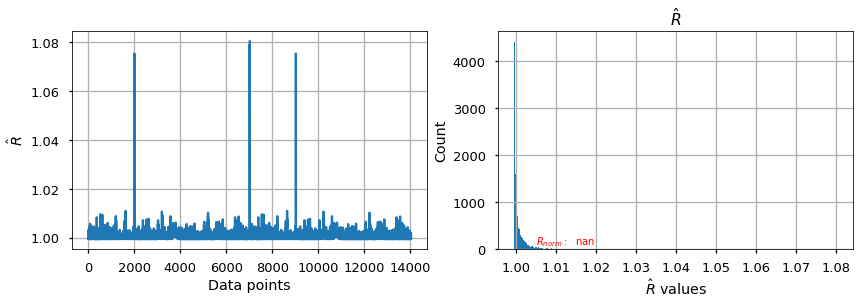

In [124]:
plot_rhat(dir_data_output, model+'_summary_'+str(chain))

## Noncenterized form of parameterization

In [14]:
! cat epileptor_sde_euler_noncen.stan

data {
    int nt;
    real dt;
    real eta_true;
    real x_init;
    real z_init;
    real xlim[2];
    real zlim[2];
    real I1;
    real tau0;
    vector[nt] xs;
}

transformed data {
}

parameters {
    vector[nt-1] x_eta;
    vector[nt-1] z_eta;
    real x_init_star;
    real z_init_star;
    real eta;  
    real <lower=0.0> amplitude;
    real offset; 
    real<lower=0.0> eps;   
    real<lower=0.0> sig;
}

transformed parameters {
}

model {
    vector[nt] xhat;
    vector[nt] zhat;

    vector[nt] x;
    vector[nt] z;
             
    x_init_star ~ normal(0., 1.); 
    z_init_star ~ normal(0., 1.); 
        
    x[1] = x_init + x_init_star;
    z[1] = z_init + z_init_star;
                      
    to_vector(x_eta) ~ normal(0., 1.);
    to_vector(z_eta) ~ normal(0., 1.);
                         
   // eta ~ normal(eta_true, 1.); 

    amplitude ~ normal(1.,1.);
    offset ~ normal(0., 1.);
    eps ~ normal(0., 1.); 
    sig ~ normal(0., 1.);
 

    for (t in 1:(nt-1)) {
 

In [125]:
model=str('epileptor_sde_euler_noncen')

In [126]:
curr_dir=cwd

In [17]:
! cd /home/meysam/cmdstan-2.17.1 && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  /home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_noncen.stan --o=/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_noncen.hpp
Model name=epileptor_sde_euler_noncen_model
Input file=/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_noncen.stan
Output file=/home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_noncen.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe    -O3 -o /home/meysam/Epileptor/Epileptor2D/epileptor_sde_euler_noncen src/cmdstan/main.cpp -include /home/meys

In [22]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=2000
warm_iter=2000

model=epileptor_sde_euler_noncen
data_input=data_input_epileptor.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [127]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [128]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen'

In [129]:
! ls $dir_data_output

epileptor_sde_euler_noncen_hmc_diagnose_2.log
epileptor_sde_euler_noncen_hmc_diagnose_4.log
epileptor_sde_euler_noncen_summary_2.csv
epileptor_sde_euler_noncen_summary_4.csv
output_hmc_epileptor_sde_euler_noncen_1.csv
output_hmc_epileptor_sde_euler_noncen_1.out
output_hmc_epileptor_sde_euler_noncen_2.csv
output_hmc_epileptor_sde_euler_noncen_2.out
output_hmc_epileptor_sde_euler_noncen_3.csv
output_hmc_epileptor_sde_euler_noncen_3.out
output_hmc_epileptor_sde_euler_noncen_4.csv
output_hmc_epileptor_sde_euler_noncen_4.out


In [130]:
!tail -n2 $dir_data_output/*$model*out

==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen/output_hmc_epileptor_sde_euler_noncen_1.out <==
               1671.67 seconds (Total)


==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen/output_hmc_epileptor_sde_euler_noncen_2.out <==
               1669.75 seconds (Total)


==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen/output_hmc_epileptor_sde_euler_noncen_3.out <==
               1672.12 seconds (Total)


==> /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen/output_hmc_epileptor_sde_euler_noncen_4.out <==
               1668.58 seconds (Total)



In [131]:
chain=1

In [132]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_epileptor_sde_euler_noncen_1.csv'

Start of report!
Report directory: /home/meysam/Epileptor/Epileptor2D
------------------------------------------------------------
dynamic_type:  stochastic_noncen
------------------------------------------------------------
Report starts!
csv file directory: /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen/output_hmc_epileptor_sde_euler_noncen_1.csv
script_dir: /home/meysam/Epileptor/Epileptor2D
repor_filename: output_hmc_epileptor_sde_euler_noncen_1
------------------------------------------------------------
parameters and their shapes: 
lp__ (2000,)
accept_stat__ (2000,)
stepsize__ (2000,)
treedepth__ (2000,)
n_leapfrog__ (2000,)
divergent__ (2000,)
energy__ (2000,)
x_eta (2000, 999)
z_eta (2000, 999)
x_init_star (2000,)
z_init_star (2000,)
eta (2000,)
amplitude (2000,)
offset (2000,)
eps (2000,)
sig (2000,)
xhat_q (2000, 1000)
zhat_q (2000, 1000)
x_ppc (2000, 1000)
z_ppc (2000, 1000)
log_lik (2000, 1000)
x (2000, 1000)
z (2000, 1000)
------------------

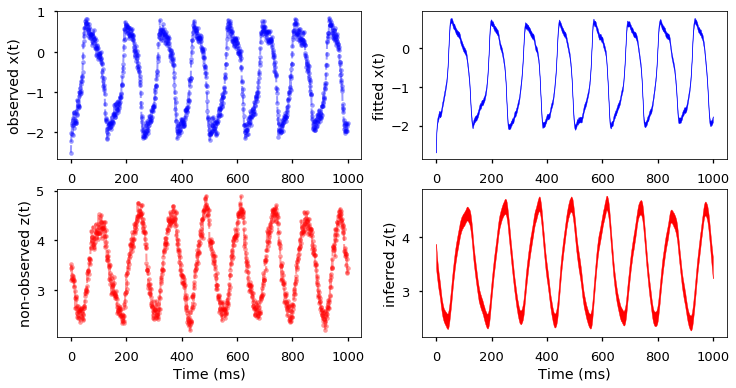

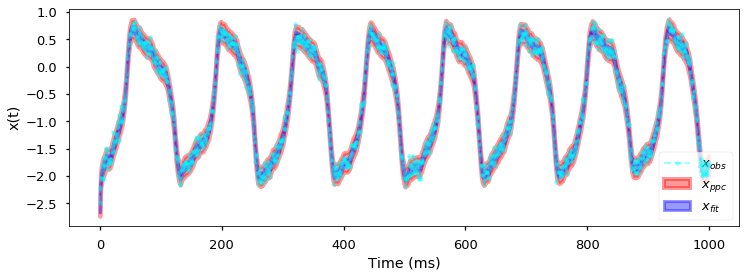

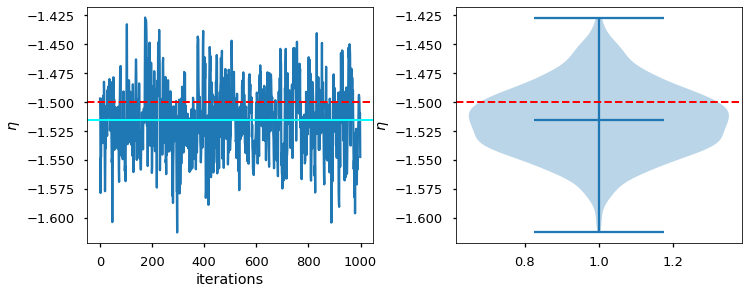

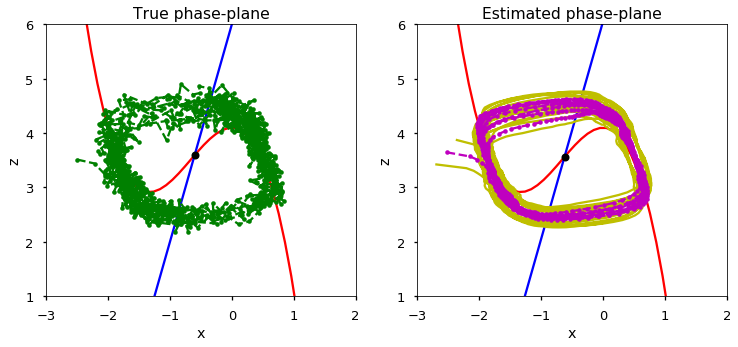

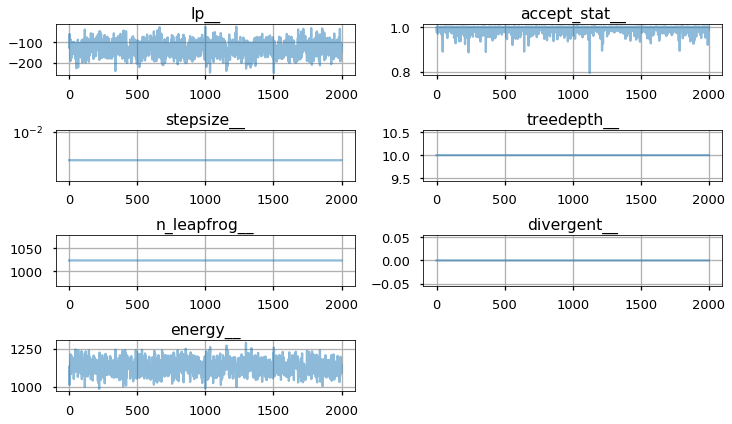

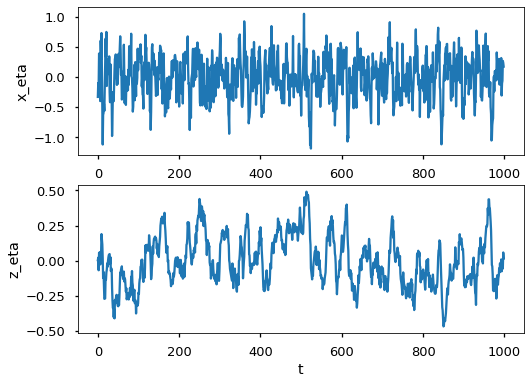

------------------------------------------------------------
End of report!
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


In [134]:
run report_epileptor2D.py $dir_data_output/$cvsfinemane

In [135]:
diagname=model+'_hmc_diagnose_'+str(chain)+'.log'
summaryname=model+'_summary_'+str(chain)+'.csv'
diagname, summaryname

('epileptor_sde_euler_noncen_hmc_diagnose_1.log',
 'epileptor_sde_euler_noncen_summary_1.csv')

In [136]:
!/home/meysam/cmdstan-2.17.1/bin/diagnose  $dir_data_output/$cvsfinemane > $dir_data_output/$diagname
! cat $dir_data_output/$diagname

2000 of 2000 (1e+02%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps. Trajectories that are prematurely terminated due to this limit will result in slow exploration and you should increase the limit to ensure optimal performance.



In [137]:
%%capture
!/home/meysam/cmdstan-2.17.1/bin/stansummary --csv_file=$dir_data_output/$summaryname $dir_data_output/$cvsfinemane

In [138]:
from stan_utility import plot_rhat

filepath: /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen
filename: epileptor_sde_euler_noncen_summary_1
mycsvfile: /home/meysam/Epileptor/Epileptor2D/data_output_hmc_epileptor_sde_euler_noncen/epileptor_sde_euler_noncen_summary_1.csv
Normalized R= 1.0001822122154298
Rhat >1.1:  0.0


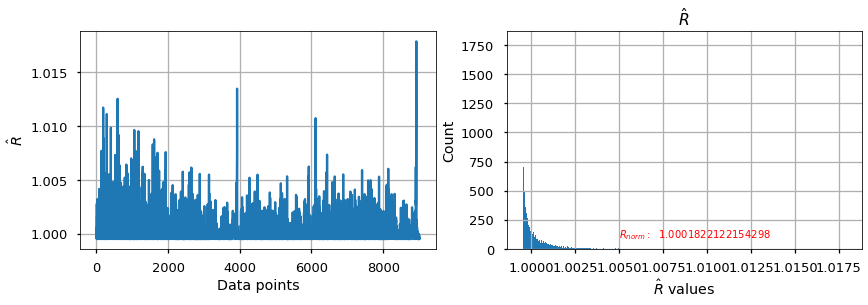

In [139]:
plot_rhat(dir_data_output, model+'_summary_'+str(chain))